In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'
os.listdir(FOLDER)

['out', 'structures.csv', 'train.csv']

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [15]:
df_structures_idx = df_structures.set_index('molecule_name')
df_train_idx = df_train.set_index('molecule_name')
mols = df_train['molecule_name'].unique()
types_3J = ['3JHH', '3JHC', '3JHN']

In [5]:
def assign_atoms_index(df_idx, molecule):
    se_0 = df_idx.loc[molecule]['atom_index_0']
    se_1 = df_idx.loc[molecule]['atom_index_1']
    if type(se_0) == np.int64:
        se_0 = pd.Series(se_0)
    if type(se_1) == np.int64:
        se_1 = pd.Series(se_1)
    assign_idx = pd.concat([se_0, se_1]).unique()
    assign_idx.sort()
    return assign_idx

In [6]:
def get_dist_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = ((loc_tile - loc_tile.T)**2).sum(axis=1)
    return dist_mat

In [7]:
def gen_df_num_bond(df_structures_idx, mol):

    dist_mat = get_dist_matrix(df_structures_idx, mol)
    df_temp = df_structures_idx.loc[mol]
    num_atoms = df_temp.shape[0]

    non_h_idx = df_temp[df_temp['atom'] != 'H']['atom_index'].values
    non_h = df_temp[df_temp['atom'] != 'H']['atom'].values

    df_non_h_dist = dist_mat[non_h_idx][:, non_h_idx]
    num_bond_list = []
    for i, idx in enumerate(non_h_idx):
        num_bond_list.append(sum((df_non_h_dist[i] > 0) * (df_non_h_dist[i] < 3)))
    num_non_h_bond = np.array(num_bond_list)

    h_idx = df_temp[df_temp['atom'] == 'H']['atom_index'].values
    h_dist_mat = dist_mat[h_idx]
    h_con_idx = h_dist_mat.argsort()[:,1]

    num_h_bond = np.zeros(num_atoms)
    for i in h_con_idx:
        num_h_bond[idx] += 1

    num_bond_non_h = num_non_h_bond + num_h_bond[non_h_idx]
    num_bond = np.ones(num_atoms)
    num_bond[non_h_idx] = num_bond_non_h

    se_num_bond = pd.Series(num_bond, name='num_bonds', dtype='int')
    se_atom = pd.Series(df_temp['atom'].values, name='atom')
    se_atom_idx = pd.Series(df_temp['atom_index'].values, name='atom_index')

    df_bond = pd.concat([se_atom, se_atom_idx, se_num_bond], axis=1)
    df_bond['molecule_name'] = mol
    return df_bond 

In [8]:
def get_pickup_dist_matrix(df_idx, df_structures_idx, molecule, num_pickup=5, atoms=['H', 'C', 'N', 'O', 'F']):
    pickup_dist_matrix = np.zeros([0, len(atoms)*num_pickup*2])
    assigned_idxs = assign_atoms_index(df_idx, molecule) # [0, 1, 2, 3, 4, 5, 6] -> [1, 2, 3, 4, 5, 6]
    dist_mat = get_dist_matrix(df_structures_idx, molecule)
    df_bond = gen_df_num_bond(df_structures_idx, molecule)
    num_bonds = df_bond['num_bonds'].values
    for idx in assigned_idxs: # [1, 2, 3, 4, 5, 6] -> [2]
        df_temp = df_structures_idx.loc[molecule]
        locs = df_temp[['x','y','z']].values

        dist_arr = dist_mat[idx] # (7, 7) -> (7, )

        atoms_mole = df_structures_idx.loc[molecule]['atom'].values # ['O', 'C', 'C', 'N', 'H', 'H', 'H']
        atoms_mole_idx = df_structures_idx.loc[molecule]['atom_index'].values # [0, 1, 2, 3, 4, 5, 6]

        mask_atoms_mole_idx = atoms_mole_idx != idx # [ True,  True, False,  True,  True,  True,  True]
        masked_atoms = atoms_mole[mask_atoms_mole_idx] # ['O', 'C', 'N', 'H', 'H', 'H']
        masked_atoms_idx = atoms_mole_idx[mask_atoms_mole_idx]  # [0, 1, 3, 4, 5, 6]
        masked_dist_arr = dist_arr[mask_atoms_mole_idx]  # [ 5.48387003, 2.15181049, 1.33269675, 10.0578779, 4.34733927, 4.34727838]
        masked_locs = locs[masked_atoms_idx]
        masked_num_bonds = num_bonds[masked_atoms_idx]

        sorting_idx = np.argsort(masked_dist_arr) # [2, 1, 5, 4, 0, 3]
        sorted_atoms_idx = masked_atoms_idx[sorting_idx] # [3, 1, 6, 5, 0, 4]
        sorted_atoms = masked_atoms[sorting_idx] # ['N', 'C', 'H', 'H', 'O', 'H']
        sorted_dist_arr = 1/masked_dist_arr[sorting_idx] #[0.75035825,0.46472494,0.23002898,0.23002576,0.18235297,0.09942455]
        sorted_num_bonds = masked_num_bonds[sorting_idx]

        target_matrix = np.zeros([len(atoms), num_pickup*2])
        for a, atom in enumerate(atoms):
            pickup_atom = sorted_atoms == atom # [False, False,  True,  True, False,  True]
            pickup_dist = sorted_dist_arr[pickup_atom] # [0.23002898, 0.23002576, 0.09942455]
            pickup_num_bond = sorted_num_bonds[pickup_atom]

            num_atom = len(pickup_dist)
            if num_atom > num_pickup:
                target_matrix[a, :num_pickup] = pickup_dist[:num_pickup]
                target_matrix[a, num_pickup:] = pickup_num_bond[:num_pickup]
            else:
                target_matrix[a, :num_atom] = pickup_dist
                target_matrix[a, num_pickup:num_pickup+num_atom] = pickup_num_bond
        
        pickup_dist_matrix = np.vstack([pickup_dist_matrix, target_matrix.reshape(-1)])
    return pickup_dist_matrix #(num_atoms, num_pickup*5)

In [9]:
def merge_atom(df, df_distance):
    df_merge_0 = pd.merge(df, df_distance, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'])
    df_merge_0_1 = pd.merge(df_merge_0, df_distance, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'])
    del df_merge_0_1['atom_index_x'], df_merge_0_1['atom_index_y']
    return df_merge_0_1

In [47]:
def gen_pairs_list(df_idx, df_structures_idx, molecule_name, type_3J):
    pairs_list = []
    df_tr = df_idx.loc[molecule_name]
    df_st = df_structures_idx.loc[molecule_name]
    if type(df_tr) == pd.Series:
        return []
    
    pairs_3J = df_tr.query('type == "{}"'.format(type_3J))[['atom_index_0','atom_index_1']].values
    dist_matrix = get_dist_matrix(df_structures_idx, molecule_name)

    for p3 in pairs_3J:
        atom_idx_0 = p3[0]

        dist_arr = dist_matrix[atom_idx_0]
        mask = dist_arr != 0
        dist_arr_excl_0 = dist_arr[mask]
        masked_idx = df_st['atom_index'].values[mask]
        atom_idx_1 = masked_idx[np.argsort(dist_arr_excl_0)[0]]

        atom_idx_3 = p3[1]
        dist_arr = dist_matrix[atom_idx_3]
        mask = dist_arr != 0
        dist_arr_excl_0 = dist_arr[mask]
        masked_idx = df_st['atom_index'].values[mask]
        atom_idx_2 = masked_idx[np.argsort(dist_arr_excl_0)[0]]        
        
        pair = [atom_idx_0, atom_idx_1, atom_idx_2, atom_idx_3]
        pairs_list.append(pair)
        
    return pairs_list

In [51]:
def get_cos_3J(df_structures_idx, molecule_name, atom_idx_list):
    pos_list = []
    df_st = df_structures_idx.loc[molecule_name]

    for idx in atom_idx_list:
        pos = df_st.query('atom_index == {}'.format(idx))[['x', 'y', 'z']].values
        pos_list.append(pos)

    v01 = pos_list[1] - pos_list[0]
    v12 = pos_list[2] - pos_list[1]
    v23 = pos_list[3] - pos_list[2]

    v01_12 = v01 - ((np.dot(v01, v12.T) / np.linalg.norm(v12) **2 ) * v12)[0]
    v23_12 = v23 - ((np.dot(v23, v12.T) / np.linalg.norm(v12) **2 ) * v12)[0]
    
    return np.dot(v01_12, v23_12.T) / np.linalg.norm(v01_12) / np.linalg.norm(v23_12)

In [73]:
col_cos = np.zeros(0)
start = time.time()
types_3J = ['3JHH', '3JHC', '3JHN']
for m in mols[:100]:
    df_tr = df_train_idx.loc[m]
    cos_arr = np.zeros([df_tr.shape[0]])
    for t in types_3J:
        pairs_list = gen_pairs_list(df_train_idx, df_structures_idx, m, t)
        if len(pairs_list) == 0:
            continue
        cos = np.zeros(0)
        for pair in pairs_list:
            cos = np.hstack([cos, get_cos_3J(df_structures_idx, m, pair)[0,0]])

        mask = df_tr['type'].values == '{}'.format(t)
        cos_arr[mask] = cos
    col_cos = np.hstack([col_cos, cos_arr])
    
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

c:\users\ryoji\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


elapsed_time:21.82663345336914[sec]


In [74]:
col_cos.shape

(2744,)

In [77]:
4519775/2744 * 22 / 3600

10.065906422092647

In [20]:
df = df_train_dist.iloc[:4519775]

In [18]:
col_cos.shape

(4519775,)

In [21]:
df['cos_3J'] = col_cos

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
df_train_dist = df.copy()

In [ ]:
# df_train_dist.to_csv(OUTPUT + 'train_dist.csv', index=False)

In [ ]:
# df_train_dist = pd.read_csv(OUTPUT + 'train_dist.csv')

In [24]:
bond_types = df_train_dist['type'].unique()

In [25]:
mols = df_train_dist['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.8)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [26]:
models = []
scores = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    model = lgb.LGBMRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val).reshape(-1)
    
    y_pred_train = model.predict(X_train).reshape(-1)
    score = type_score(y_val, y_pred)
    scores = np.hstack([scores, score])
    print('type score:', score)
    models.append(model)
print('total score:', scores.mean())

type score: 0.5053377885518755
type score: -0.8466693670451279
type score: -0.5274332307751013
type score: -0.8090948539343528
type score: -0.17463603205141548
type score: 0.3851629988329044
type score: 0.5238713253556644
type score: -0.9650840387046294
total score: -0.2385681762212728


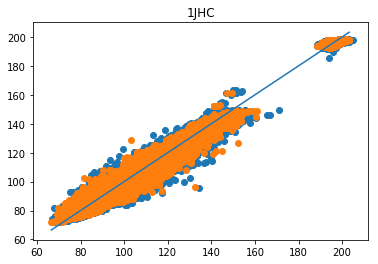

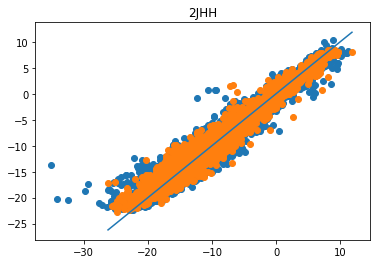

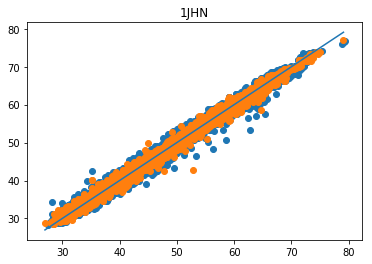

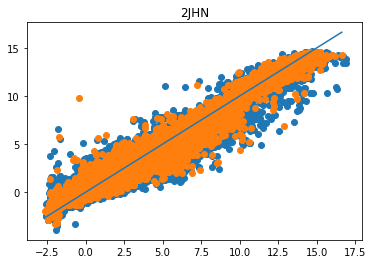

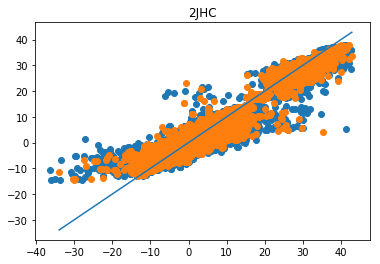

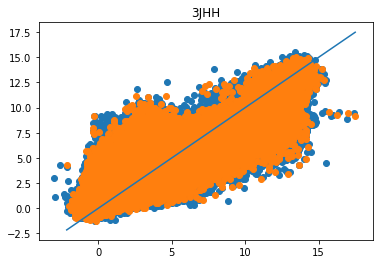

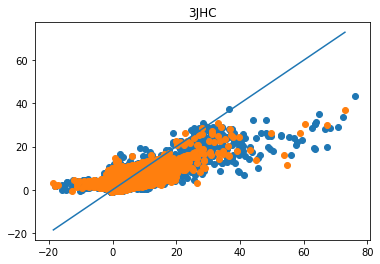

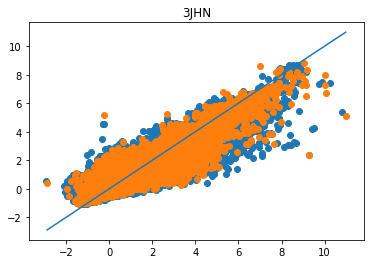

In [28]:
for i, b in enumerate(bond_types):
    df = df_train_dist.query('type == "{}"'.format(b))
    y = df['scalar_coupling_constant'].values
    X = df[df.columns[6:]].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    model = models[i]
    
    y_pred = model.predict(X_val)
    y_pred_train = model.predict(X_train)
    plt.scatter(y_train, y_pred_train)
    plt.scatter(y_val, y_pred)
    plt.title('{}'.format(b))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
    plt.show()

In [ ]:
df_train_dist.to_csv(OUTPUT + 'train_dist_cos.csv', index=False)

In [ ]:
with open(OUTPUT + '20190610_champs_models_lgb.pickle', 'wb') as f:
    pickle.dump(models, f)